# Application of Explainable Machine Learning on Prediction

## Dataset: wdbc

*   20 Features
*   569 Observations
*   Predict class: [1, 2]



### Loading Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=0f9fbb0acca19e6449772269e86f5b80c2df9c4484731d26949c6f4288672af5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import uniform, randint
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lime
import lime.lime_tabular
import shap

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [ ]:
# Load the data
wdbc = pd.read_csv('wdbc.csv')
wdbc.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,class
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,2
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,2
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,2
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,2


In [ ]:
wdbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  569 non-null    int64  
 1   V1          569 non-null    float64
 2   V2          569 non-null    float64
 3   V3          569 non-null    float64
 4   V4          569 non-null    float64
 5   V5          569 non-null    float64
 6   V6          569 non-null    float64
 7   V7          569 non-null    float64
 8   V8          569 non-null    float64
 9   V9          569 non-null    float64
 10  V10         569 non-null    float64
 11  V11         569 non-null    float64
 12  V12         569 non-null    float64
 13  V13         569 non-null    float64
 14  V14         569 non-null    float64
 15  V15         569 non-null    float64
 16  V16         569 non-null    float64
 17  V17         569 non-null    float64
 18  V18         569 non-null    float64
 19  V19         569 non-null    f

In [ ]:
# Drop Unnamed column
wdbc = wdbc.drop(columns = 'Unnamed: 0')

# Encode the class label to [0, 1]
label_encoder = LabelEncoder()
wdbc['class'] = label_encoder.fit_transform(wdbc['class'])

# Check missing data
wdbc.isnull().sum().sum()

0

In [ ]:
wdbc.describe()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,class
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,284.000000,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,1.372583
std,164.400426,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,1.000000
25%,142.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,1.000000
50%,284.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,426.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,2.000000
max,568.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,2.000000


There's no missing value.

In [ ]:
# Display the data
wdbc.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


### Data Visualization

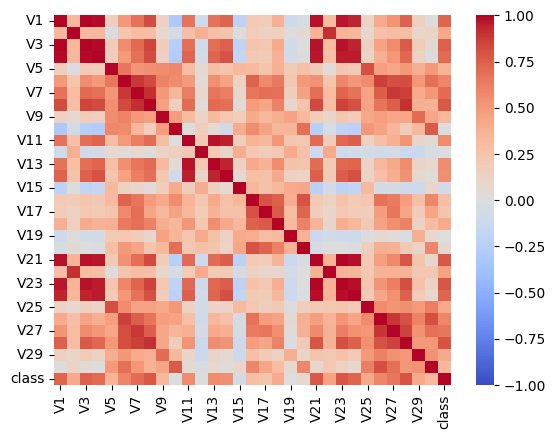

In [ ]:
# Correlation Map
corr = wdbc.corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=False, cmap='coolwarm')
plt.show()

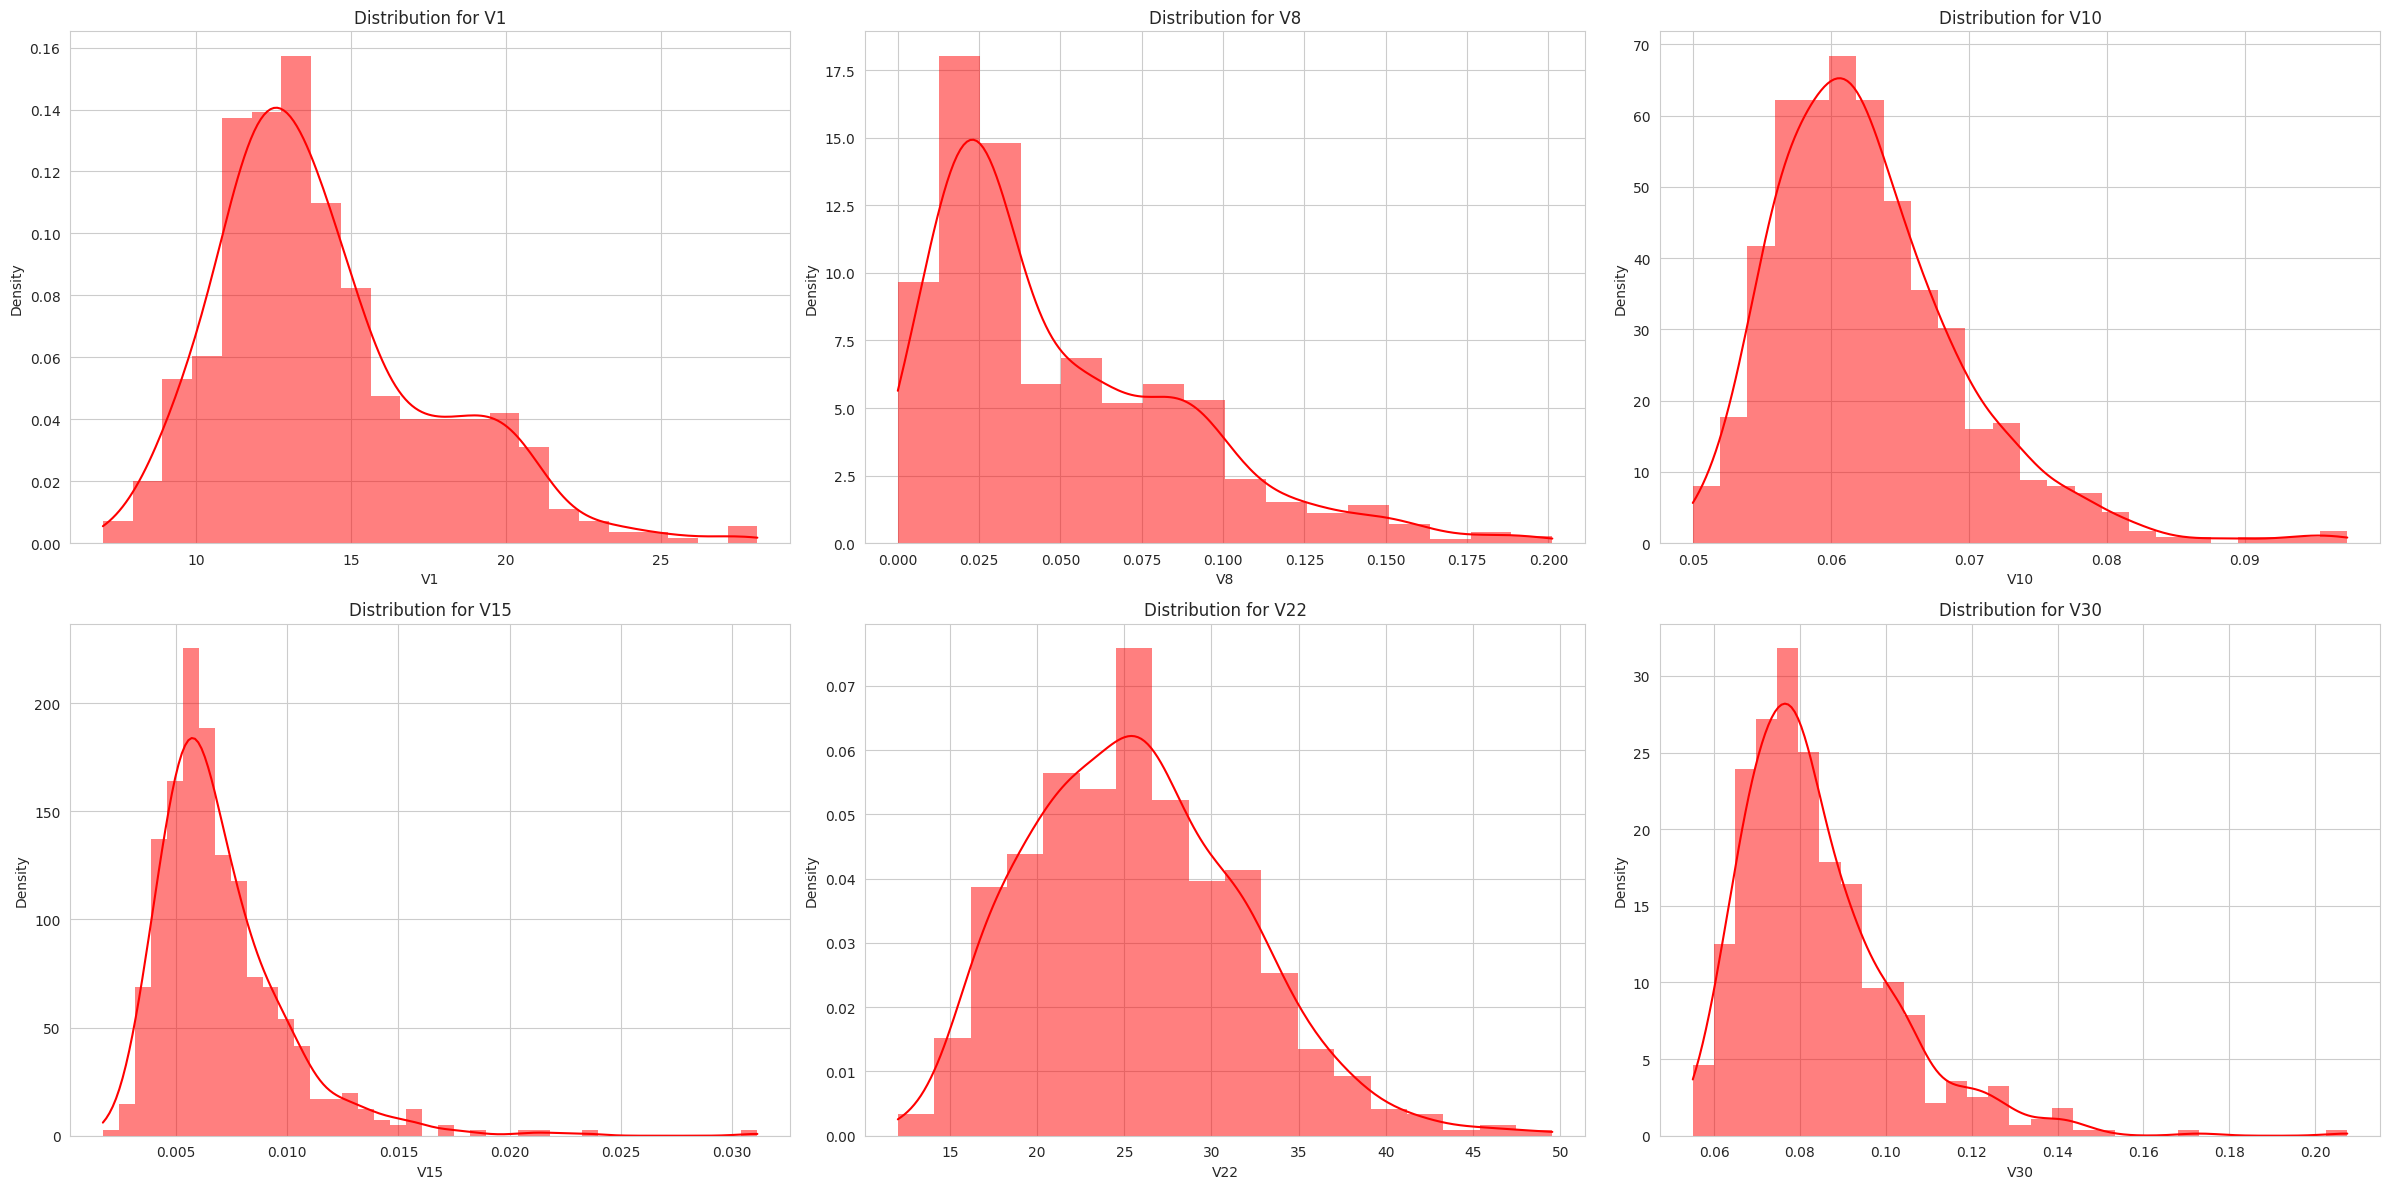

In [ ]:
# Select some features
var = ['V1', 'V8', 'V10', 'V15', 'V22', 'V30']

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Plot layout
n_rows = 2
n_cols = 3
plt.figure(figsize=(24, 12))

# Loop through the features and create a histogram for each
for i, v in enumerate(var):
  plt.subplot(n_rows, n_cols, i + 1)
  sns.histplot(wdbc[v], kde=True, color='red', stat="density", linewidth=0)
  plt.title(f'Distribution for {v}')
  plt.xlabel(v)
  plt.ylabel('Density')

# Display the plots
plt.tight_layout()
plt.show()

Numerical features are distributed over different value ranges, thus standardization is needed.

### Data Preprocessing

In [ ]:
# Identify features and labels
X = wdbc.drop('class', axis=1)
y = wdbc['class']

# Split the data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

### Model Building & Evaluation

#### Logistic Regression

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(random_state = 42)
lr_model.fit(X_train, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluation
lr_report = classification_report(y_test, y_pred_lr, target_names = label_encoder.classes_.astype(str))
accuracy_lr = accuracy_score(y_test, y_pred_lr)
log_loss_lr = log_loss(y_test, y_pred_proba_lr)

# Results
print('Logistics Regression Evaluation\n')
print(lr_report)
print(f'Accuracy: {accuracy_lr}\nLog Loss: {log_loss_lr}')

Logistics Regression Evaluation

              precision    recall  f1-score   support

           1       0.97      0.99      0.98        71
           2       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9736842105263158
Log Loss: 0.06014109585947168


#### K-Nearest Neighbors

In [ ]:
# KNN
knn = KNeighborsClassifier()

# Find best n_neighbors by cross-validation
k_grid = {'n_neighbors': range(1, 30),
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']
          }
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn_cv = GridSearchCV(knn, k_grid, cv=kf)

# Train model
knn_cv.fit(X_train, y_train)
knn_model = knn_cv.best_estimator_ # best KNN model

# Prediction
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Evaluation
knn_report = classification_report(y_test, y_pred_knn, target_names = label_encoder.classes_.astype(str))
accuracy_knn = accuracy_score(y_test, y_pred_knn)
log_loss_knn = log_loss(y_test, y_pred_proba_knn)

# Results
print('K-Nearest Neighbors Evaluation\n')
print(knn_report)
print(f'Accuracy: {accuracy_knn}\nLog Loss: {log_loss_knn}')

K-Nearest Neighbors Evaluation

              precision    recall  f1-score   support

           1       0.96      0.96      0.96        71
           2       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Accuracy: 0.9473684210526315
Log Loss: 0.3896289215694664


#### Support Vector Machine

In [ ]:
# Support Vector Machine
svm_model = SVC(probability = True, random_state = 42)
svm_model.fit(X_train, y_train)

# Prediction
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluation
svm_report = classification_report(y_test, y_pred_svm, target_names = label_encoder.classes_.astype(str))
accuracy_svm = accuracy_score(y_test, y_pred_svm)
log_loss_svm = log_loss(y_test, y_pred_proba_svm)

# Results
print('Support Vector Machine Evaluation\n')
print(svm_report)
print(f'Accuracy: {accuracy_svm}\nLog Loss: {log_loss_svm}')

Support Vector Machine Evaluation

              precision    recall  f1-score   support

           1       0.97      1.00      0.99        71
           2       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Accuracy: 0.9824561403508771
Log Loss: 0.07672894641653288


#### Decision Tree

In [ ]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Prediction
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluation
dt_report = classification_report(y_test, y_pred_dt, target_names = label_encoder.classes_.astype(str))
accuracy_dt = accuracy_score(y_test, y_pred_dt)
log_loss_dt = log_loss(y_test, y_pred_proba_dt)

# Results
print('Decision Tree Evaluation\n')
print(dt_report)
print(f'Accuracy: {accuracy_dt}\nLog Loss: {log_loss_dt}')

Decision Tree Evaluation

              precision    recall  f1-score   support

           1       0.95      0.97      0.96        71
           2       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Accuracy: 0.9473684210526315
Log Loss: 0.7604405560972337


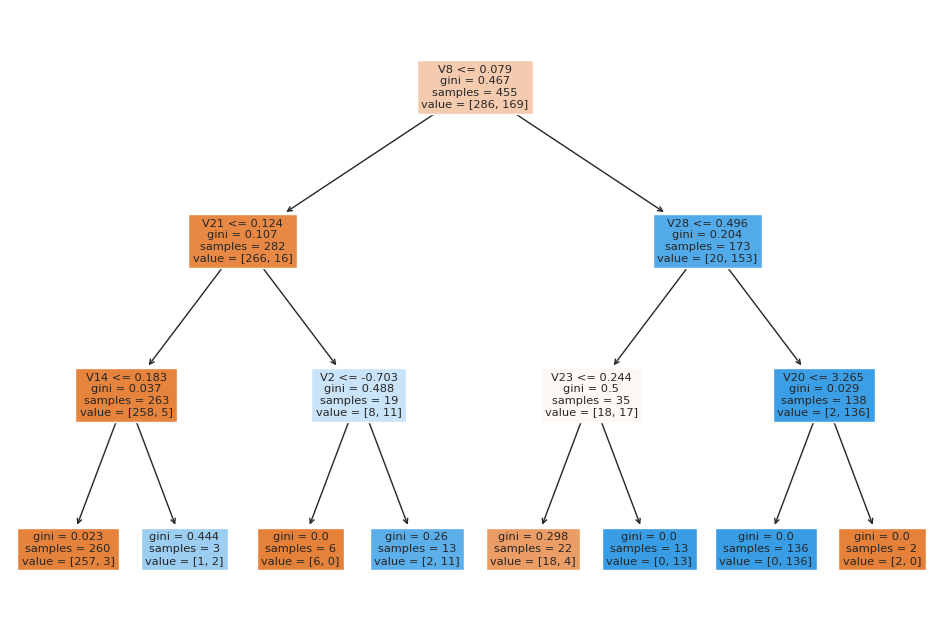

In [ ]:
# Visualize Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model, filled=True, feature_names = X.columns.tolist())
plt.show()

#### Random Forest

In [ ]:
# Random Forest
# Find best model through cross validation
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
           'max_features': ['auto', 'sqrt'],
           'max_depth': max_depth,
           'min_samples_split': randint(2,20),
           'min_samples_leaf': randint(1,10),
           'bootstrap': [True, False]}

rf_cv = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 42),
                           param_distributions = rf_grid,
                           n_iter = 100, cv = 3, verbose = 2, n_jobs = -1)

# Train model
rf_cv.fit(X_train, y_train)
rf_model = rf_cv.best_estimator_ # best random forest model

# Prediction
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
rf_report = classification_report(y_test, y_pred_rf, target_names = label_encoder.classes_.astype(str))
accuracy_rf = accuracy_score(y_test, y_pred_rf)
log_loss_rf = log_loss(y_test, y_pred_proba_rf)

# Results
print('Random Forest Evaluation (Baseline)\n')
print(rf_report)
print(f'Accuracy: {accuracy_rf}\nLog Loss: {log_loss_rf}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Random Forest Evaluation (Baseline)

              precision    recall  f1-score   support

           1       0.96      0.99      0.97        71
           2       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Accuracy: 0.9649122807017544
Log Loss: 0.093503621212334


#### AdaBoost

In [ ]:
# AdaBoost
ab_model = AdaBoostClassifier(random_state = 42)
ab_model.fit(X_train, y_train)

# Prediction
y_pred_ab = ab_model.predict(X_test)
y_pred_proba_ab = ab_model.predict_proba(X_test)[:, 1]

# Evaluation
ab_report = classification_report(y_test, y_pred_ab, target_names = label_encoder.classes_.astype(str))
accuracy_ab = accuracy_score(y_test, y_pred_ab)
log_loss_ab = log_loss(y_test, y_pred_proba_ab)

# Results
print('AdaBoost Evaluation\n')
print(ab_report)
print(f'Accuracy: {accuracy_ab}\nLog Loss: {log_loss_ab}')

AdaBoost Evaluation

              precision    recall  f1-score   support

           1       0.97      0.99      0.98        71
           2       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9736842105263158
Log Loss: 0.4849816432993528


#### XGBoost

In [ ]:
# XGBoost
xgb_grid = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.5, 1),
    'min_child_weight': randint(1, 5),
    'subsample': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.4),
    'reg_alpha': uniform(0, 40),
    'reg_lambda': uniform(0, 1)
}

xgb_cv = RandomizedSearchCV(
    XGBClassifier(objective='binary:logistic'), # binary classification
    param_distributions = xgb_grid,
    n_iter = 100,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose = 3,
    random_state = 42
)

# Train model
xgb_cv.fit(X_train, y_train)
xgb_model = xgb_cv.best_estimator_ # best XGBoost model

# Prediction
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
xgb_report = classification_report(y_test, y_pred_xgb, target_names = label_encoder.classes_.astype(str))
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
log_loss_xgb = log_loss(y_test, y_pred_proba_xgb)

# Results
print('XGBoost Evaluation\n')
print(xgb_report)
print(f'Accuracy: {accuracy_xgb}\nLog Loss: {log_loss_xgb}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBoost Evaluation

              precision    recall  f1-score   support

           1       0.97      0.99      0.98        71
           2       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9736842105263158
Log Loss: 0.08892532364039389


#### Neural Network

In [ ]:
# Neural Network
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Build model
neural_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]), # add layers
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
neural_model.compile(loss='binary_crossentropy', # for binary classification
              optimizer='adam',
              metrics=['accuracy'])

# Train model
history_neural = neural_model.fit(X_train, y_train, epochs = 25,
                                  batch_size = 32, verbose = 1, validation_split = 0.2)

Epoch 1/25
12/12 [==============================] - 1s 26ms/step - loss: 0.5119 - accuracy: 0.8214 - val_loss: 0.3421 - val_accuracy: 0.9121
Epoch 2/25
12/12 [==============================] - 0s 6ms/step - loss: 0.2893 - accuracy: 0.9396 - val_loss: 0.2171 - val_accuracy: 0.9341
Epoch 3/25
12/12 [==============================] - 0s 7ms/step - loss: 0.1903 - accuracy: 0.9478 - val_loss: 0.1614 - val_accuracy: 0.9560
Epoch 4/25
12/12 [==============================] - 0s 6ms/step - loss: 0.1383 - accuracy: 0.9560 - val_loss: 0.1338 - val_accuracy: 0.9560
Epoch 5/25
12/12 [==============================] - 0s 6ms/step - loss: 0.1102 - accuracy: 0.9670 - val_loss: 0.1179 - val_accuracy: 0.9560
Epoch 6/25
12/12 [==============================] - 0s 7ms/step - loss: 0.0922 - accuracy: 0.9725 - val_loss: 0.1111 - val_accuracy: 0.9670
Epoch 7/25
12/12 [==============================] - 0s 7ms/step - loss: 0.0792 - accuracy: 0.9808 - val_loss: 0.1071 - val_accuracy: 0.9670
Epoch 8/25
12/12 [=

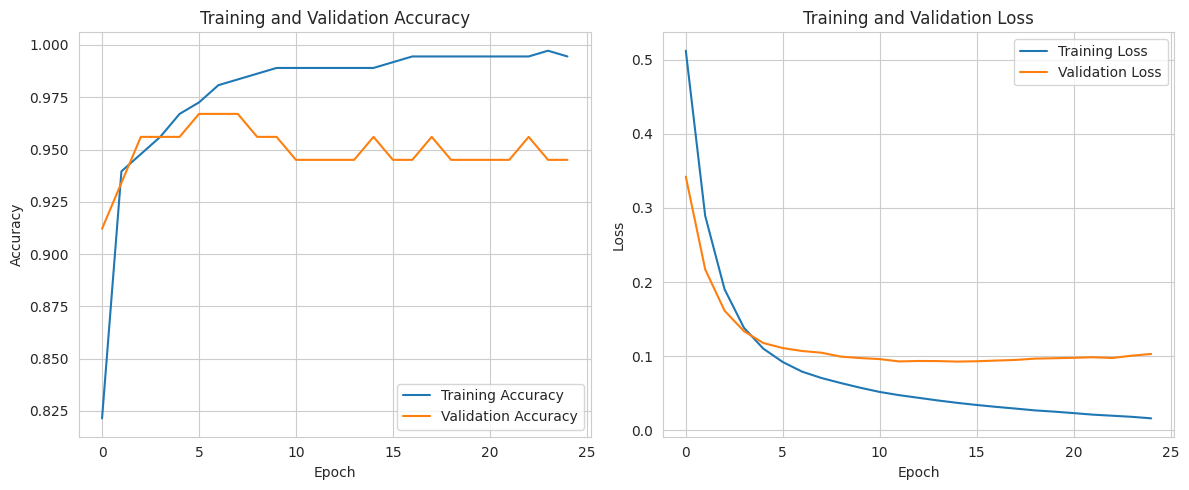

In [ ]:
# Traning Accuracy and Loss Visualization
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history_neural.history['accuracy'], label='Training Accuracy')
plt.plot(history_neural.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_neural.history['loss'], label='Training Loss')
plt.plot(history_neural.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prediction
y_pred_proba_neural = neural_model.predict(X_test).flatten()
y_pred_neural = (y_pred_proba_neural > 0.5).astype(int)

# Evaluation
neural_report = classification_report(y_test, y_pred_neural, target_names = label_encoder.classes_.astype(str))
log_loss_neural = log_loss(y_test, y_pred_proba_neural)
accuracy_neural = accuracy_score(y_test, y_pred_neural)

# Results
print('Neural Network Evaluation\n')
print(neural_report)
print(f'Accuracy: {accuracy_neural}\nLog Loss: {log_loss_neural}')

4/4 [==============================] - 0s 3ms/step
Neural Network Evaluation

              precision    recall  f1-score   support

           1       0.97      0.99      0.98        71
           2       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy: 0.9736842105263158
Log Loss: 0.0653011417250474


### Model Selection

#### ROC Curve

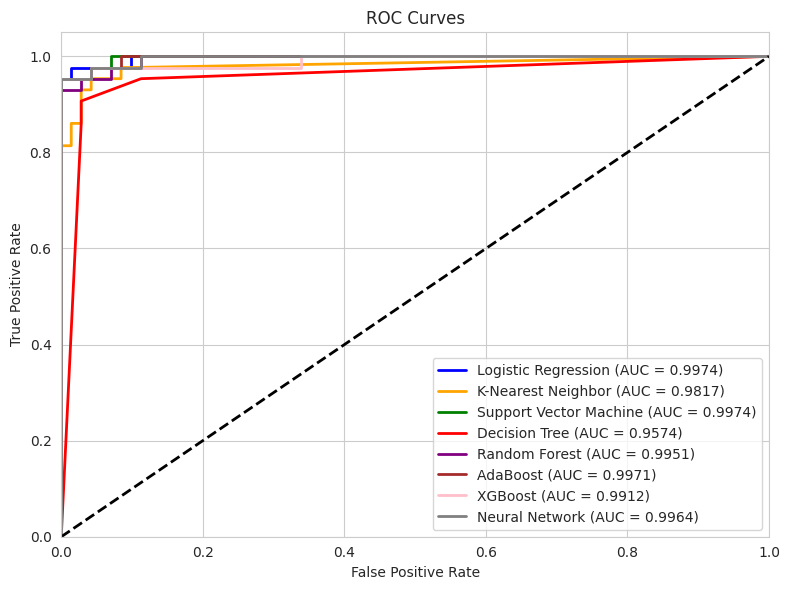

In [ ]:
# Setup plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
model_predictions = [
    (y_pred_proba_lr, 'Logistic Regression'),
    (y_pred_proba_knn, 'K-Nearest Neighbor'),
    (y_pred_proba_svm, 'Support Vector Machine'),
    (y_pred_proba_dt, 'Decision Tree'),
    (y_pred_proba_rf, 'Random Forest'),
    (y_pred_proba_ab, 'AdaBoost'),
    (y_pred_proba_xgb, 'XGBoost'),
    (y_pred_proba_neural, 'Neural Network')
]

# Plot ROC curve for each model
for model_proba, title in model_predictions:
    fpr, tpr, _ = roc_curve(y_test, model_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=next(colors), lw=2, label=f'{title} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc="lower right")

# Display the plot
plt.tight_layout()
plt.show()

#### Performance Metrics

In [ ]:
# Model names
model = ['Logistic Regression', 'K-Nearest Neighbor', 'Support Vector Machine',
         'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'Neural Network']

# Performance metrics
performance = {
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_svm, accuracy_dt,
                 accuracy_rf, accuracy_ab, accuracy_xgb, accuracy_neural],
    'Log Loss': [log_loss_lr, log_loss_knn, log_loss_svm, log_loss_dt,
                 log_loss_rf, log_loss_ab, log_loss_xgb, log_loss_neural],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_knn),
        roc_auc_score(y_test, y_pred_proba_svm),
        roc_auc_score(y_test, y_pred_proba_dt),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_ab),
        roc_auc_score(y_test, y_pred_proba_xgb),
        roc_auc_score(y_test, y_pred_proba_neural)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_ab),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_neural)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_ab),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_neural)
    ],
    'F1 Score (macro)': [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_knn, average='macro'),
        f1_score(y_test, y_pred_svm, average='macro'),
        f1_score(y_test, y_pred_dt, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_ab, average='macro'),
        f1_score(y_test, y_pred_xgb, average='macro'),
        f1_score(y_test, y_pred_neural, average='macro')
    ],
    'F1 Score (micro)': [
        f1_score(y_test, y_pred_lr, average='micro'),
        f1_score(y_test, y_pred_knn, average='micro'),
        f1_score(y_test, y_pred_svm, average='micro'),
        f1_score(y_test, y_pred_dt, average='micro'),
        f1_score(y_test, y_pred_rf, average='micro'),
        f1_score(y_test, y_pred_ab, average='micro'),
        f1_score(y_test, y_pred_xgb, average='micro'),
        f1_score(y_test, y_pred_neural, average='micro')
    ],
    'F1 Score (weighted)': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_knn, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted'),
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_ab, average='weighted'),
        f1_score(y_test, y_pred_xgb, average='weighted'),
        f1_score(y_test, y_pred_neural, average='weighted')
    ]
}

performance_df = pd.DataFrame(performance, index=model).sort_values(by=['Accuracy', 'ROC AUC'], ascending=False)
print(performance_df)

                        Accuracy  Log Loss   ROC AUC  Precision    Recall  \
Support Vector Machine  0.982456  0.076729  0.997380   1.000000  0.953488   
Logistic Regression     0.973684  0.060141  0.997380   0.976190  0.953488   
AdaBoost                0.973684  0.484982  0.997052   0.976190  0.953488   
Neural Network          0.973684  0.065301  0.996397   0.976190  0.953488   
XGBoost                 0.973684  0.088925  0.991156   0.976190  0.953488   
Random Forest           0.964912  0.093504  0.995087   0.975610  0.930233   
K-Nearest Neighbor      0.947368  0.389629  0.981657   0.930233  0.930233   
Decision Tree           0.947368  0.760441  0.957419   0.951220  0.906977   

                        F1 Score (macro)  F1 Score (micro)  \
Support Vector Machine          0.981151          0.982456   
Logistic Regression             0.971863          0.973684   
AdaBoost                        0.971863          0.973684   
Neural Network                  0.971863          0.973684

**Support Vector Machine** is the best model based on the performance metrics.

### Feature Evaluation

In [ ]:
# Convert X_train, X_test to dataframe for LIME and SHAP
X_train_df = pd.DataFrame(X_train, columns=wdbc.drop('class', axis=1).columns)
X_test_df = pd.DataFrame(X_test, columns=wdbc.drop('class', axis=1).columns)

#### LIME

In [ ]:
# Create a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train_df.values,
    feature_names = X_train_df.columns.tolist(),
    class_names = label_encoder.classes_.astype(str),
    mode = 'classification'
)

# LIME Explaination (only show 1 instance as example since there are a lot features displayed)
explanation = lime_explainer.explain_instance(X_test_df.values[91], svm_model.predict_proba, num_features=len(X_train_df.columns))
explanation.show_in_notebook(show_table=True, show_all=False)

In [ ]:
n = X_test_df.shape[0] # sample size
feature_score_lime = {feature: 0 for feature in X_train_df.columns}

for i in range(n):
  explanation = lime_explainer.explain_instance(X_test_df.values[i], svm_model.predict_proba, num_features=len(X_train_df.columns))
  exp_list = explanation.as_list()

  for tup in exp_list:
    feature, score = tup[0], tup[1]

    # Get total influential score for each feature
    for key, value in feature_score_lime.items():
      if key in feature:
        feature_score_lime[key] += abs(score)

# Get average influential value
for key, value in feature_score_lime.items():
  feature_score_lime[key] /= n

# Sort the dictionary by values
sorted_feature_lime = sorted(feature_score_lime.items(), key=lambda x: x[1])

# Create a DataFrame to display the result
df_feature_lime = pd.DataFrame(sorted_feature_lime, columns=['Feature', 'Score'])
df_feature_lime.head()

,Feature,Score
0,V5,0.008799
1,V9,0.009272
2,V18,0.009401
3,V26,0.011513
4,V6,0.012043


#### SHAP

In [ ]:
# Initialize Explainer
shap_explainer = shap.KernelExplainer(svm_model.predict_proba, X_train)

# Compute SHAP values for the test set
shap_values = shap_explainer.shap_values(X_test)

# Random select instances for explanation example
indices = np.random.choice(X_test.shape[0], size=3, replace=False)

for i in indices:
    shap.initjs()
    print(f"Index: {i}")

    for class_index in range(shap_values.shape[2]):  # Loop through each class
        explainer_value = shap_explainer.expected_value[class_index]
        shap_values_class = shap_values[i, :, class_index]

        # Display the SHAP force plot for each class for the selected instance
        print(f"Class Index: {class_index}")
        plot = shap.force_plot(explainer_value, shap_values_class, X_test_df.iloc[i, :], link="logit", show = False)
        display(plot)

  0%|          | 0/114 [00:00<?, ?it/s]

Index: 28
Class Index: 0


Class Index: 1


Index: 6
Class Index: 0


Class Index: 1


Index: 101
Class Index: 0


Class Index: 1


**General Interpretation**\
f(x): The base value, which indicates the average model output (probability) over the training set for certain class.\
Red arrows: Indicate feature values that push the prediction higher than the base value for a given class.\
Blue arrows: Indicate feature values that pull the prediction lower than the base value for that class.\
Length of arrows: Represents the magnitude of the feature's contribution to the prediction.\
Position of the feature label: Indicates the actual value of that feature for the instance being explained.\
The output value for the prediction is the final position on the x-axis after all the feature contributions have been taken into account. If it is greater than the base value, the model predicts that this instance is more likely to be in that class; if it is less, it predicts it is less likely to be in the class.

In [ ]:
# Convert the list of SHAP values for each class into an array
shap_values_array = np.stack(shap_values, axis=1)

# Compute the mean of the absolute SHAP values across the selected instances for each feature
mean_abs_shap_values = np.abs(shap_values_array).mean(axis=0)
if mean_abs_shap_values.ndim > 1:
    mean_abs_shap_values = mean_abs_shap_values.mean(axis=1)

# Create a dictionary for feature scores
feature_score_shap = {feature: mean_abs_shap_values[idx] for idx, feature in enumerate(X_train_df.columns)}
sorted_feature_shap = sorted(feature_score_shap.items(), key=lambda x: x[1])

# Create a DataFrame to display the result
df_feature_shap = pd.DataFrame(sorted_feature_shap, columns=['Feature', 'Score'])
df_feature_shap.head()

,Feature,Score
0,V5,0.012439
1,V4,0.012836
2,V1,0.012867
3,V26,0.013449
4,V29,0.013566


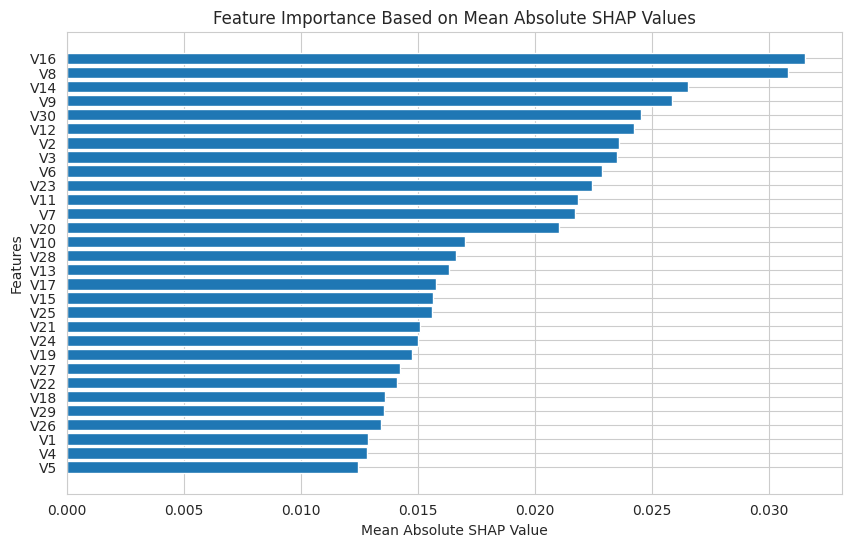

In [ ]:
if mean_abs_shap_values.ndim > 1:
    mean_abs_shap_values = mean_abs_shap_values.mean(axis=1)

# Sort the feature importances by their mean absolute SHAP values
feature_score_shap = {feature: mean_abs_shap_values[idx] for idx, feature in enumerate(X_train_df.columns)}
sorted_feature_importances = sorted(feature_score_shap.items(), key=lambda x: x[1], reverse=True)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), [score for feature, score in sorted_feature_importances], tick_label=[feature for feature, score in sorted_feature_importances])
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title('Feature Importance Based on Mean Absolute SHAP Values')
plt.gca().invert_yaxis()  # most important feature at the top
plt.show()

### Model Optimization

#### After LIME

In [ ]:
# Drop non-influential features
drop_features_lime = ['V5', 'V9', 'V18', 'V26', 'V6']
X_train_lime = X_train_df.drop(columns = drop_features_lime)
X_test_lime = X_test_df.drop(columns = drop_features_lime)

# Retrain SVM
lime_model = SVC(probability = True, random_state = 42)
lime_model.fit(X_train_lime, y_train)

# Prediction
y_pred_lime = lime_model.predict(X_test_lime)
y_pred_proba_lime = lime_model.predict_proba(X_test_lime)[:, 1]

# Evaluation
lime_report = classification_report(y_test, y_pred_lime, target_names = label_encoder.classes_.astype(str))
accuracy_lime = accuracy_score(y_test, y_pred_lime)
log_loss_lime = log_loss(y_test, y_pred_proba_lime)

# Results
print('Support Vector Machine Evaluation (LIME)\n')
print(lime_report)
print(f'Accuracy: {accuracy_lime}\nLog Loss: {log_loss_lime}')

Support Vector Machine Evaluation (LIME)

              precision    recall  f1-score   support

           1       0.97      1.00      0.99        71
           2       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Accuracy: 0.9824561403508771
Log Loss: 0.07211568531486867


#### After SHAP

In [ ]:
# Drop the identified non-influential features from the training and test sets
drop_features_shap = ['V5', 'V4', 'V1', 'V26', 'V29']
X_train_shap = X_train_df.drop(columns=drop_features_shap)
X_test_shap = X_test_df.drop(columns=drop_features_shap)

# Fit the model on the reduced feature set
shap_model = SVC(probability = True, random_state = 42)
shap_model.fit(X_train_shap, y_train)

# Predictions
y_pred_shap = shap_model.predict(X_test_shap)
y_pred_proba_shap = shap_model.predict_proba(X_test_shap)[:, 1]

# Evaluation
shap_report = classification_report(y_test, y_pred_shap, target_names = label_encoder.classes_.astype(str))
accuracy_shap = accuracy_score(y_test, y_pred_shap)
log_loss_shap = log_loss(y_test, y_pred_proba_shap)

# Print results
print('Support Vector Machine Evaluation (SHAP-Informed Model)\n')
print(shap_report)
print(f'Accuracy: {accuracy_shap}\nLog Loss: {log_loss_shap}')

Support Vector Machine Evaluation (SHAP-Informed Model)

              precision    recall  f1-score   support

           1       0.97      1.00      0.99        71
           2       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Accuracy: 0.9824561403508771
Log Loss: 0.059834234238914624


### Comparison

#### ROC Curve

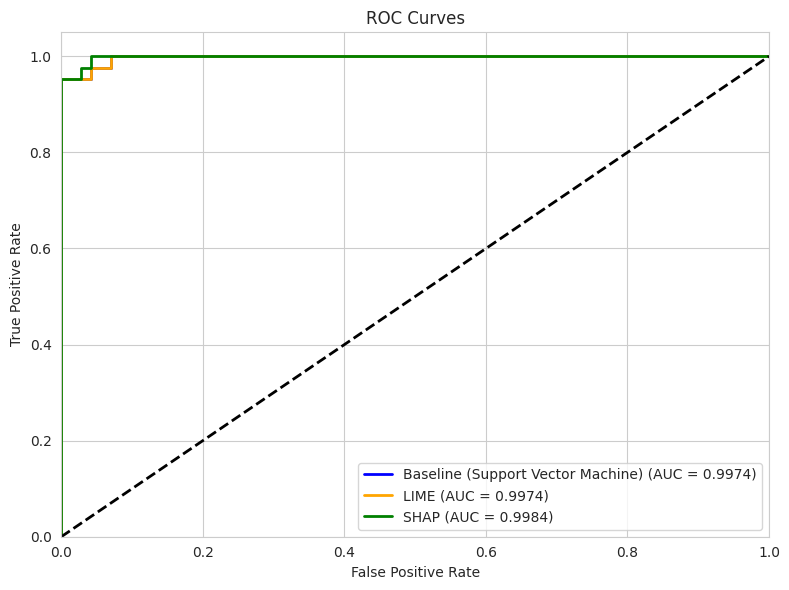

In [ ]:
# Setup plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = cycle(['blue', 'orange', 'green'])
eml_predictions = [
    (y_pred_proba_svm, 'Baseline (Support Vector Machine)'),
    (y_pred_proba_lime, 'LIME'),
    (y_pred_proba_shap, 'SHAP')
]

# Plot ROC curve for each model
for model_proba, title in eml_predictions:
    fpr, tpr, _ = roc_curve(y_test, model_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=next(colors), lw=2, label=f'{title} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc="lower right")

# Display the plot
plt.tight_layout()
plt.show()

#### Performance Metrics

In [ ]:
# Index
eml_index = ['Baseline (Support Vector Machine)', 'LIME', 'SHAP']

# Performance metrics
performance_eml = {
    'Accuracy': [accuracy_svm, accuracy_lime, accuracy_shap],
    'Log Loss': [log_loss_svm, log_loss_lime, log_loss_shap],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_svm),
        roc_auc_score(y_test, y_pred_proba_lime),
        roc_auc_score(y_test, y_pred_proba_shap)
    ],
    'Precision': [
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_lime),
        precision_score(y_test, y_pred_shap)
    ],
    'Recall': [
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_lime),
        recall_score(y_test, y_pred_shap)
    ],
    'F1 Score (macro)': [
        f1_score(y_test, y_pred_svm, average='macro'),
        f1_score(y_test, y_pred_lime, average='macro'),
        f1_score(y_test, y_pred_shap, average='macro')
    ],
    'F1 Score (micro)': [
        f1_score(y_test, y_pred_svm, average='micro'),
        f1_score(y_test, y_pred_lime, average='micro'),
        f1_score(y_test, y_pred_shap, average='micro')
    ],
    'F1 Score (weighted)': [
        f1_score(y_test, y_pred_svm, average='weighted'),
        f1_score(y_test, y_pred_lime, average='weighted'),
        f1_score(y_test, y_pred_shap, average='weighted')
    ]
}

eml_compare = pd.DataFrame(performance_eml, index=eml_index).sort_values(by=['Accuracy'], ascending=False)
print(eml_compare)

                                   Accuracy  Log Loss   ROC AUC  Precision  \
Baseline (Support Vector Machine)  0.982456  0.076729  0.997380        1.0   
LIME                               0.982456  0.072116  0.997380        1.0   
SHAP                               0.982456  0.059834  0.998362        1.0   

                                     Recall  F1 Score (macro)  \
Baseline (Support Vector Machine)  0.953488          0.981151   
LIME                               0.953488          0.981151   
SHAP                               0.953488          0.981151   

                                   F1 Score (micro)  F1 Score (weighted)  
Baseline (Support Vector Machine)          0.982456             0.982369  
LIME                                       0.982456             0.982369  
SHAP                                       0.982456             0.982369  


### Summary Plot

  0%|          | 0/114 [00:00<?, ?it/s]

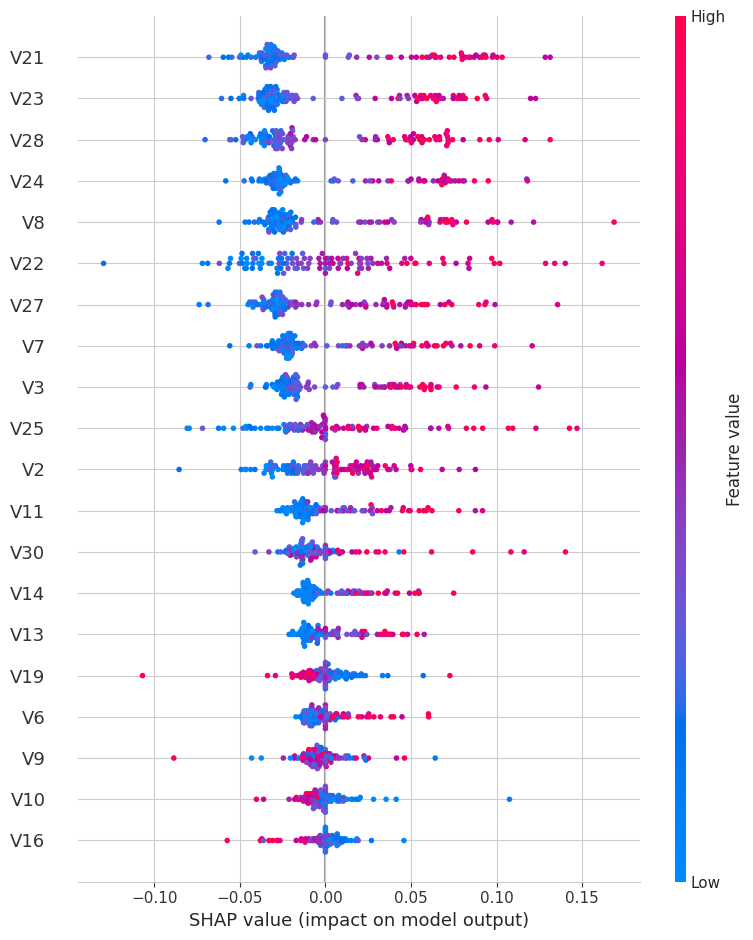

In [ ]:
class SHAPModelEvaluator:
    def __init__(self, model, X_train_df, X_test_df, y_train, drop_features):
        self.model = model
        self.X_train_df = X_train_df
        self.X_test_df = X_test_df
        self.y_train = y_train
        self.drop_features = drop_features

    def generate_summary_plot(self):
        # Reduce the feature set based on SHAP feature importance
        X_train_shap = self.X_train_df.drop(columns=self.drop_features)
        X_test_shap = self.X_test_df.drop(columns=self.drop_features)

        # Fit the model on the reduced feature set
        X_train_shap_sampled = shap.kmeans(X_train_shap, 100) # sample the training data
        self.model.fit(X_train_shap, self.y_train)

        # Create a SHAP explainer
        explainer = shap.KernelExplainer(self.model.predict, X_train_shap_sampled, link="identity")

        # Calculate SHAP values for the test set
        shap_values = explainer.shap_values(X_test_shap)

        # Generate summary plot
        shap.summary_plot(shap_values, X_test_shap)

evaluator = SHAPModelEvaluator(shap_model, X_train_df, X_test_df, y_train, drop_features_shap)

# Generate and display the summary plot
evaluator.generate_summary_plot()